# 2- Time-series Signal Metrics  

This file to be executed second

Haytham Mohamed - INFS890 - Spring 2020

Using metrics as time-series data to predict future latency. The data collected from prometheus metrics output directly. Treated as raw observations signals from the application without apply transformation rules processing.

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
sns.set(color_codes=True)

pd.set_option("display.precision", 2)
pd.options.display.float_format = '{:.2f}'.format

In [2]:
home_dir = '/Users/hmohamed/github/data-research-spring2020'

input_dir = home_dir '/raw-data-linode-run3/merged/'  # this is prepared raw metrics signals
input_file = 'all_data.csv'

output_dir = input_dir                 # output dir for raw signal metrics data
output_file = 'raw_timeseries_data.csv'

target = 'service_ltcy_200'

features = ['service_cpu_use'
            , 'service_memory_use'
            , 'service_cpu_sat'
            , 'service_net_usage'
            , 'service_disk_usage'
            , 'service_req_total'
            , 'service_errors'
            , 'service_request_size'
            , 'service_response_size'
            , 'containers_count'
            , 'system_cpu_usage'
           ]

TARGET_DIFF=False
FEATURES_DIFF=False

TARGET_RATE=True
FEATURES_RATE=True

TARGET_PERCENTILE=True

resample_time_window='S'

rate_time_window = '1T'  # S for second , T for minute
skip = 1 * 60

latency_percentile = 0.95

SAVE=True


In [3]:
data_df = pd.read_csv(input_dir + input_file, header=None, skiprows=1, names=['date', 'value', 'metric'])
data_df.head(5)


,date,value,metric
0,2020-02-27 22:49:53,4601.81,service_cpu_use
1,2020-02-27 22:49:54,9482.57,service_cpu_use
2,2020-02-27 22:49:55,9482.57,service_cpu_use
3,2020-02-27 22:49:56,13088.54,service_cpu_use
4,2020-02-27 22:49:57,13328.66,service_cpu_use


In [4]:
data_df.shape

(946107, 3)

In [5]:
def extractMetricSeries(df, name):
    metric = df.loc[df['metric'] == name].drop(['metric'], axis=1).rename(index=str, columns={"value": name})
    metric.date = pd.to_datetime(metric.date)
    metric[name] = pd.to_numeric(metric[name])
    metric.set_index('date', inplace=True)
    metric.sort_index()
    return metric

# T for minutes, S for seconds
def resample(df, frequency = resample_time_window, interpolate = True, interpolate_method = 'linear', base=6):
    # fill in missing interval (upsample)
    resampled = df.resample(frequency, kind='timestamp', base=base).bfill()
    if interpolate:
        resampled = resampled.interpolate(method=interpolate_method)
    resampled.sort_index()
    return resampled

def plot_series(df):
    df.plot(figsize=(20,10), linewidth=2, fontsize=20)
    plt.xlabel('Time', fontsize=20);
    plt.show()
    
def diff_series(df):
    # eliminate seasonality, taking first diff
    return df.diff()[1:]       

def merge(df, series):
    return pd.merge_asof(df, series, left_index=True, right_index=True, tolerance=pd.Timedelta('15 second')).bfill()    
    
def clear_null(df):
    return df[df[target].notna()]  

def eliminate_zeros(df, col):
    return df[df[col] > 0.00]

# df is a timeseries and resampled per second
# window in a form of nS or nT  or nH , where n is an interger (S for seconds, T for minutes, H for hours)
def rate(df, col, interval='S'):    
    #df = df.resample('S', kind='timestamp', base=6).bfill()
    df[col] = df.pct_change(fill_method='ffill', freq=interval)  # change per second
    #df = df.resample(interval, kind='timestamp', base=6).mean()
    df = df.dropna(axis=0, subset=[col])    
    return df
    
def rate_series(df, interval):
    metric = df.metric[0]
    df = df.drop('metric', 1)
    df = rate(df, 'value', interval)
    df['metric'] = metric

# Target  Latency 

In [6]:
print("Processing metric: %", target)
target_df = extractMetricSeries(data_df, target)

nulls = target_df.isnull().sum()
target_df.head(3)

Processing metric: % service_ltcy_200


,service_ltcy_200
date,
2020-02-27 22:49:53,1012763.00
2020-02-27 22:49:54,1016583.00
2020-02-27 22:49:55,1016583.00


In [7]:

target_df = resample(target_df, interpolate=False) 
target_df.shape

(78841, 1)

In [8]:
# check number of nulls
nulls = target_df.isnull().sum()
nulls

service_ltcy_200    0
dtype: int64

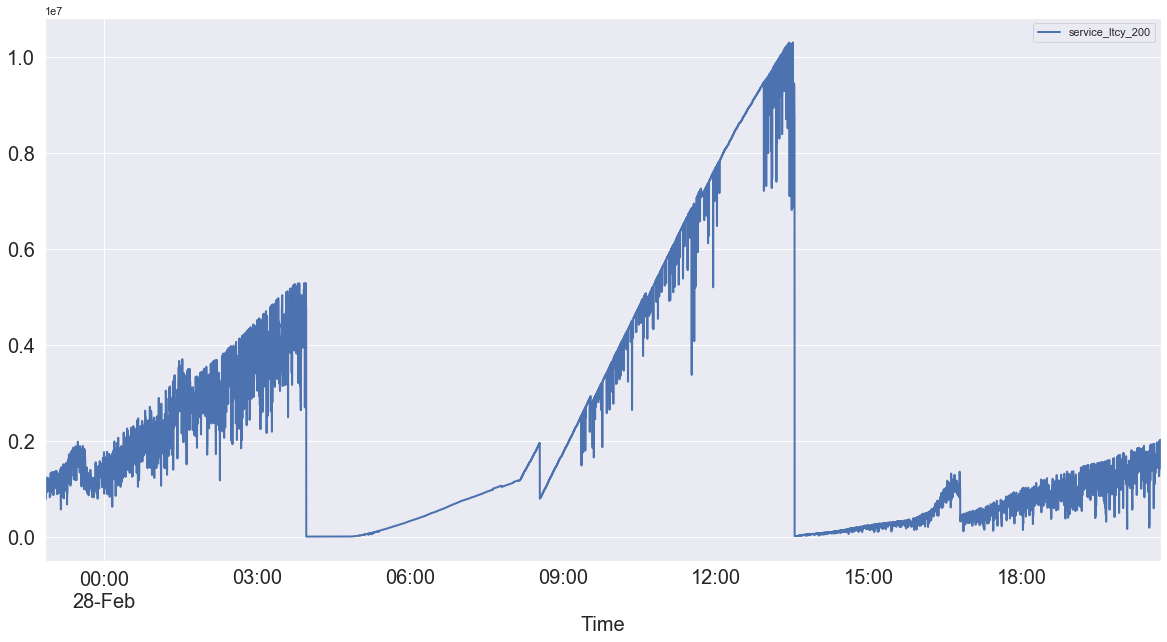

In [9]:
plot_series(target_df)

 ## Latency transformation

In [10]:
# convert latency to percentile of rate change
if TARGET_RATE:
    target_df = target_df.pct_change(fill_method='bfill', freq=rate_time_window)
    target_df = target_df[skip:]   
elif TARGET_DIFF:
    target_diff = target_df.diff() 
    target_df = target_df[skip:]

if TARGET_PERCENTILE:
    target_df = target_df.groupby(['date']).quantile(latency_percentile)
    target_df = target_df[1:]
        
target_df.sort_index() 
target_df.head(3)

,service_ltcy_200
date,
2020-02-27 22:50:54,-0.23
2020-02-27 22:50:55,-0.23
2020-02-27 22:50:56,-0.23


In [11]:
# check number of nulls
nulls = target_df.isnull().sum()
nulls

service_ltcy_200    0
dtype: int64

In [12]:
# check zero values
nulls = target_df[target_df[target] == 0].sum()
nulls

service_ltcy_200   0.00
dtype: float64

In [13]:
target_df.shape

(78780, 1)

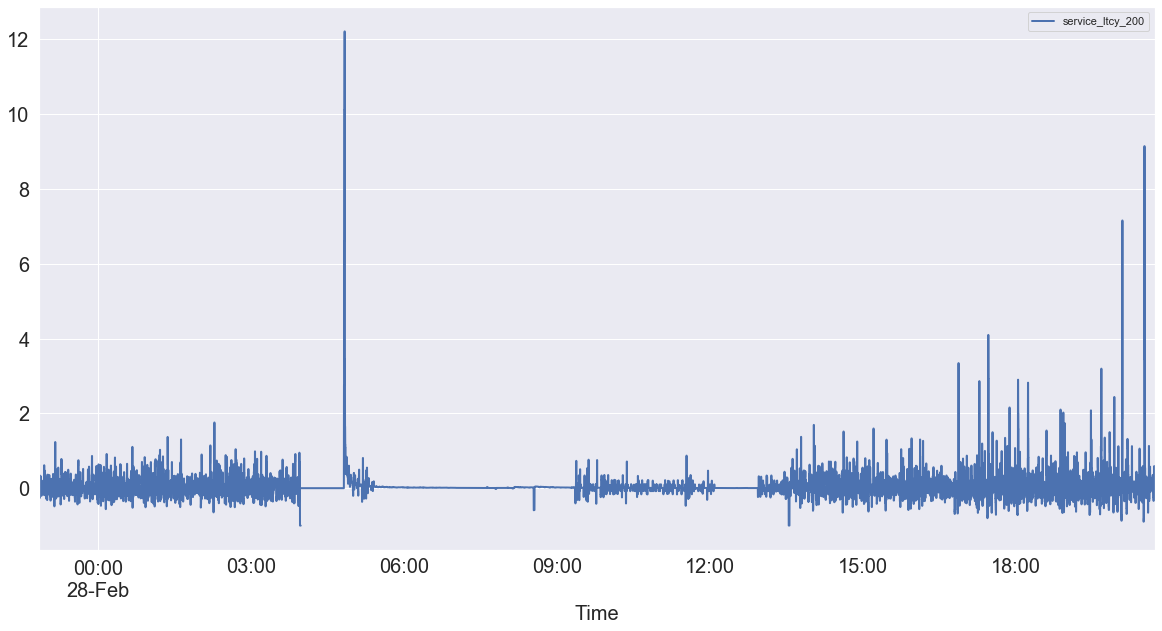

In [14]:
plot_series(target_df)

# Features: 

Processing metric: % service_cpu_use
Processing metric: % service_memory_use
Processing metric: % service_cpu_sat
Processing metric: % service_net_usage
Processing metric: % service_disk_usage
Processing metric: % service_req_total
Processing metric: % service_errors
Processing metric: % service_request_size
Processing metric: % service_response_size
Processing metric: % containers_count
Processing metric: % system_cpu_usage


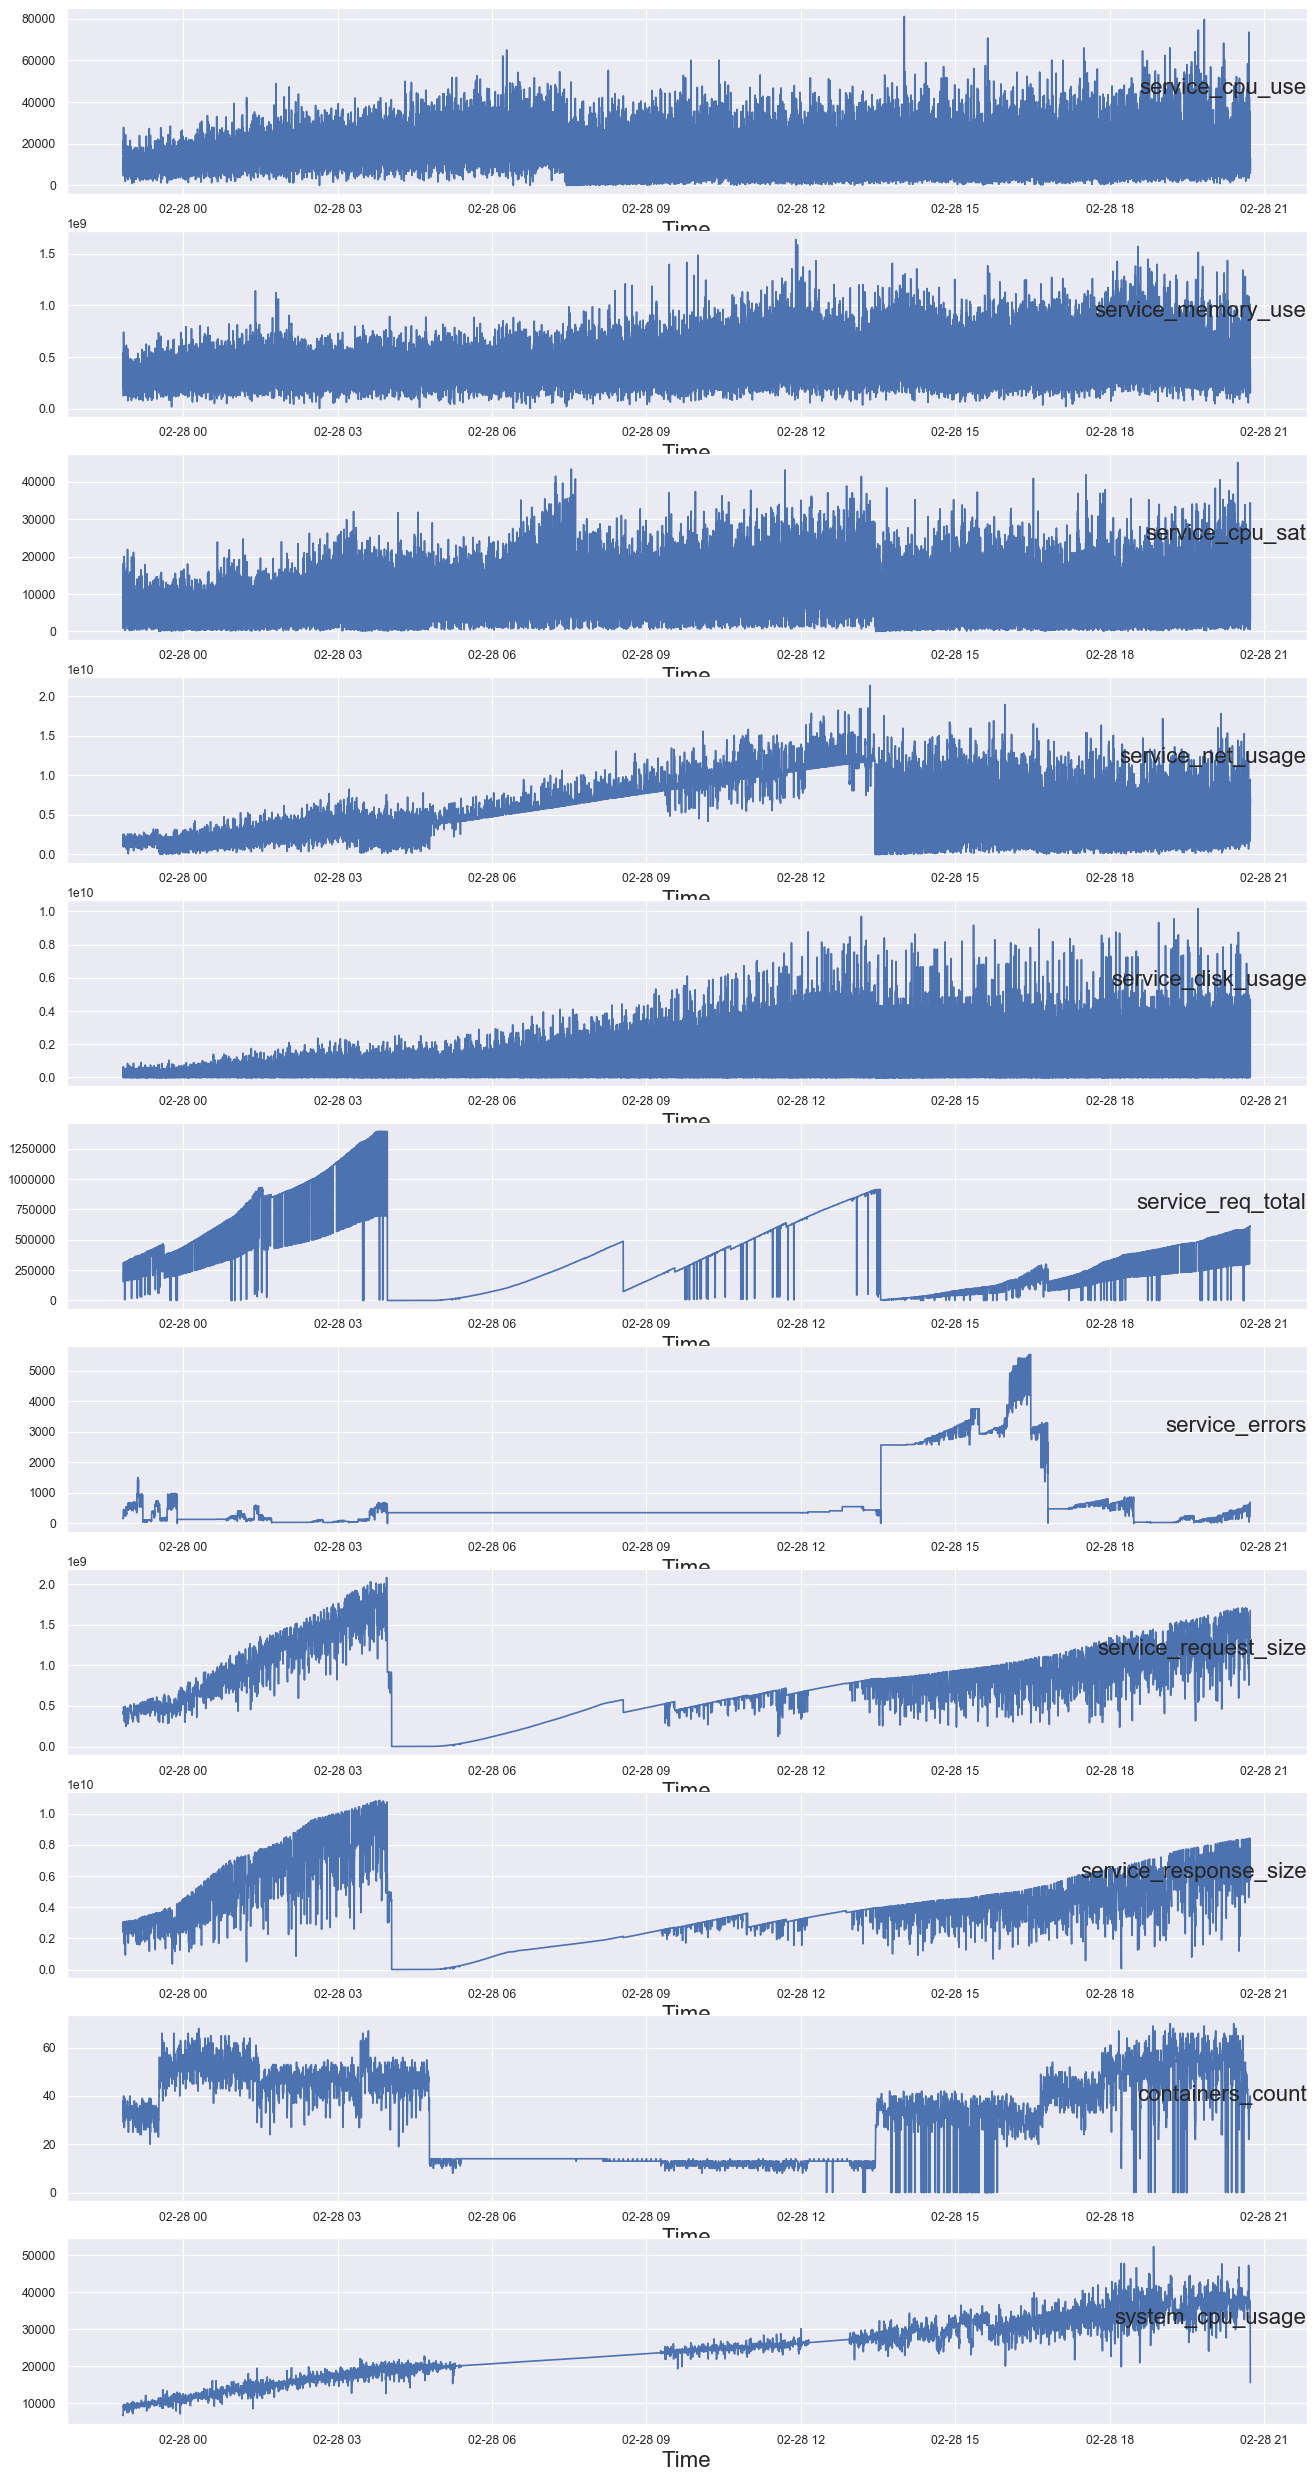

In [15]:
# merging feature columns

rows = len(features)
i = 1

plt.figure(figsize=(20, 40), dpi=80, facecolor='w', edgecolor='k')

for feature in features:
    print("Processing metric: %", feature)
    feature_series = extractMetricSeries(data_df, feature)
    feature_series = resample(feature_series)    
    #feature_series = diff_series(feature_series)      # Taking the difference   
    if i == 1:
        features_df = pd.DataFrame(feature_series)
    else:
        features_df = merge(features_df, feature_series)
    plt.subplot(rows, 1, i)
    plt.plot(feature_series)
    plt.title(feature, y=0.5, loc='right', fontsize=20)
    plt.xlabel('Time', fontsize=20)
    i += 1
    

features_df.sort_index()    
plt.show()    
    

In [16]:
features_df.shape

(78845, 11)

## Features transformation

In [17]:
# Rate in change
 
if FEATURES_RATE:    
    features_df = features_df.pct_change(fill_method='ffill', freq=rate_time_window)  # take percent chagne rate
    features_df = features_df[skip:]
elif FEATURES_DIFF:
    features_df = features_df.diff()      # Taking the difference 
    features_df = features_df[skip:]

features_df.sort_index()
features_df.shape

(78785, 11)

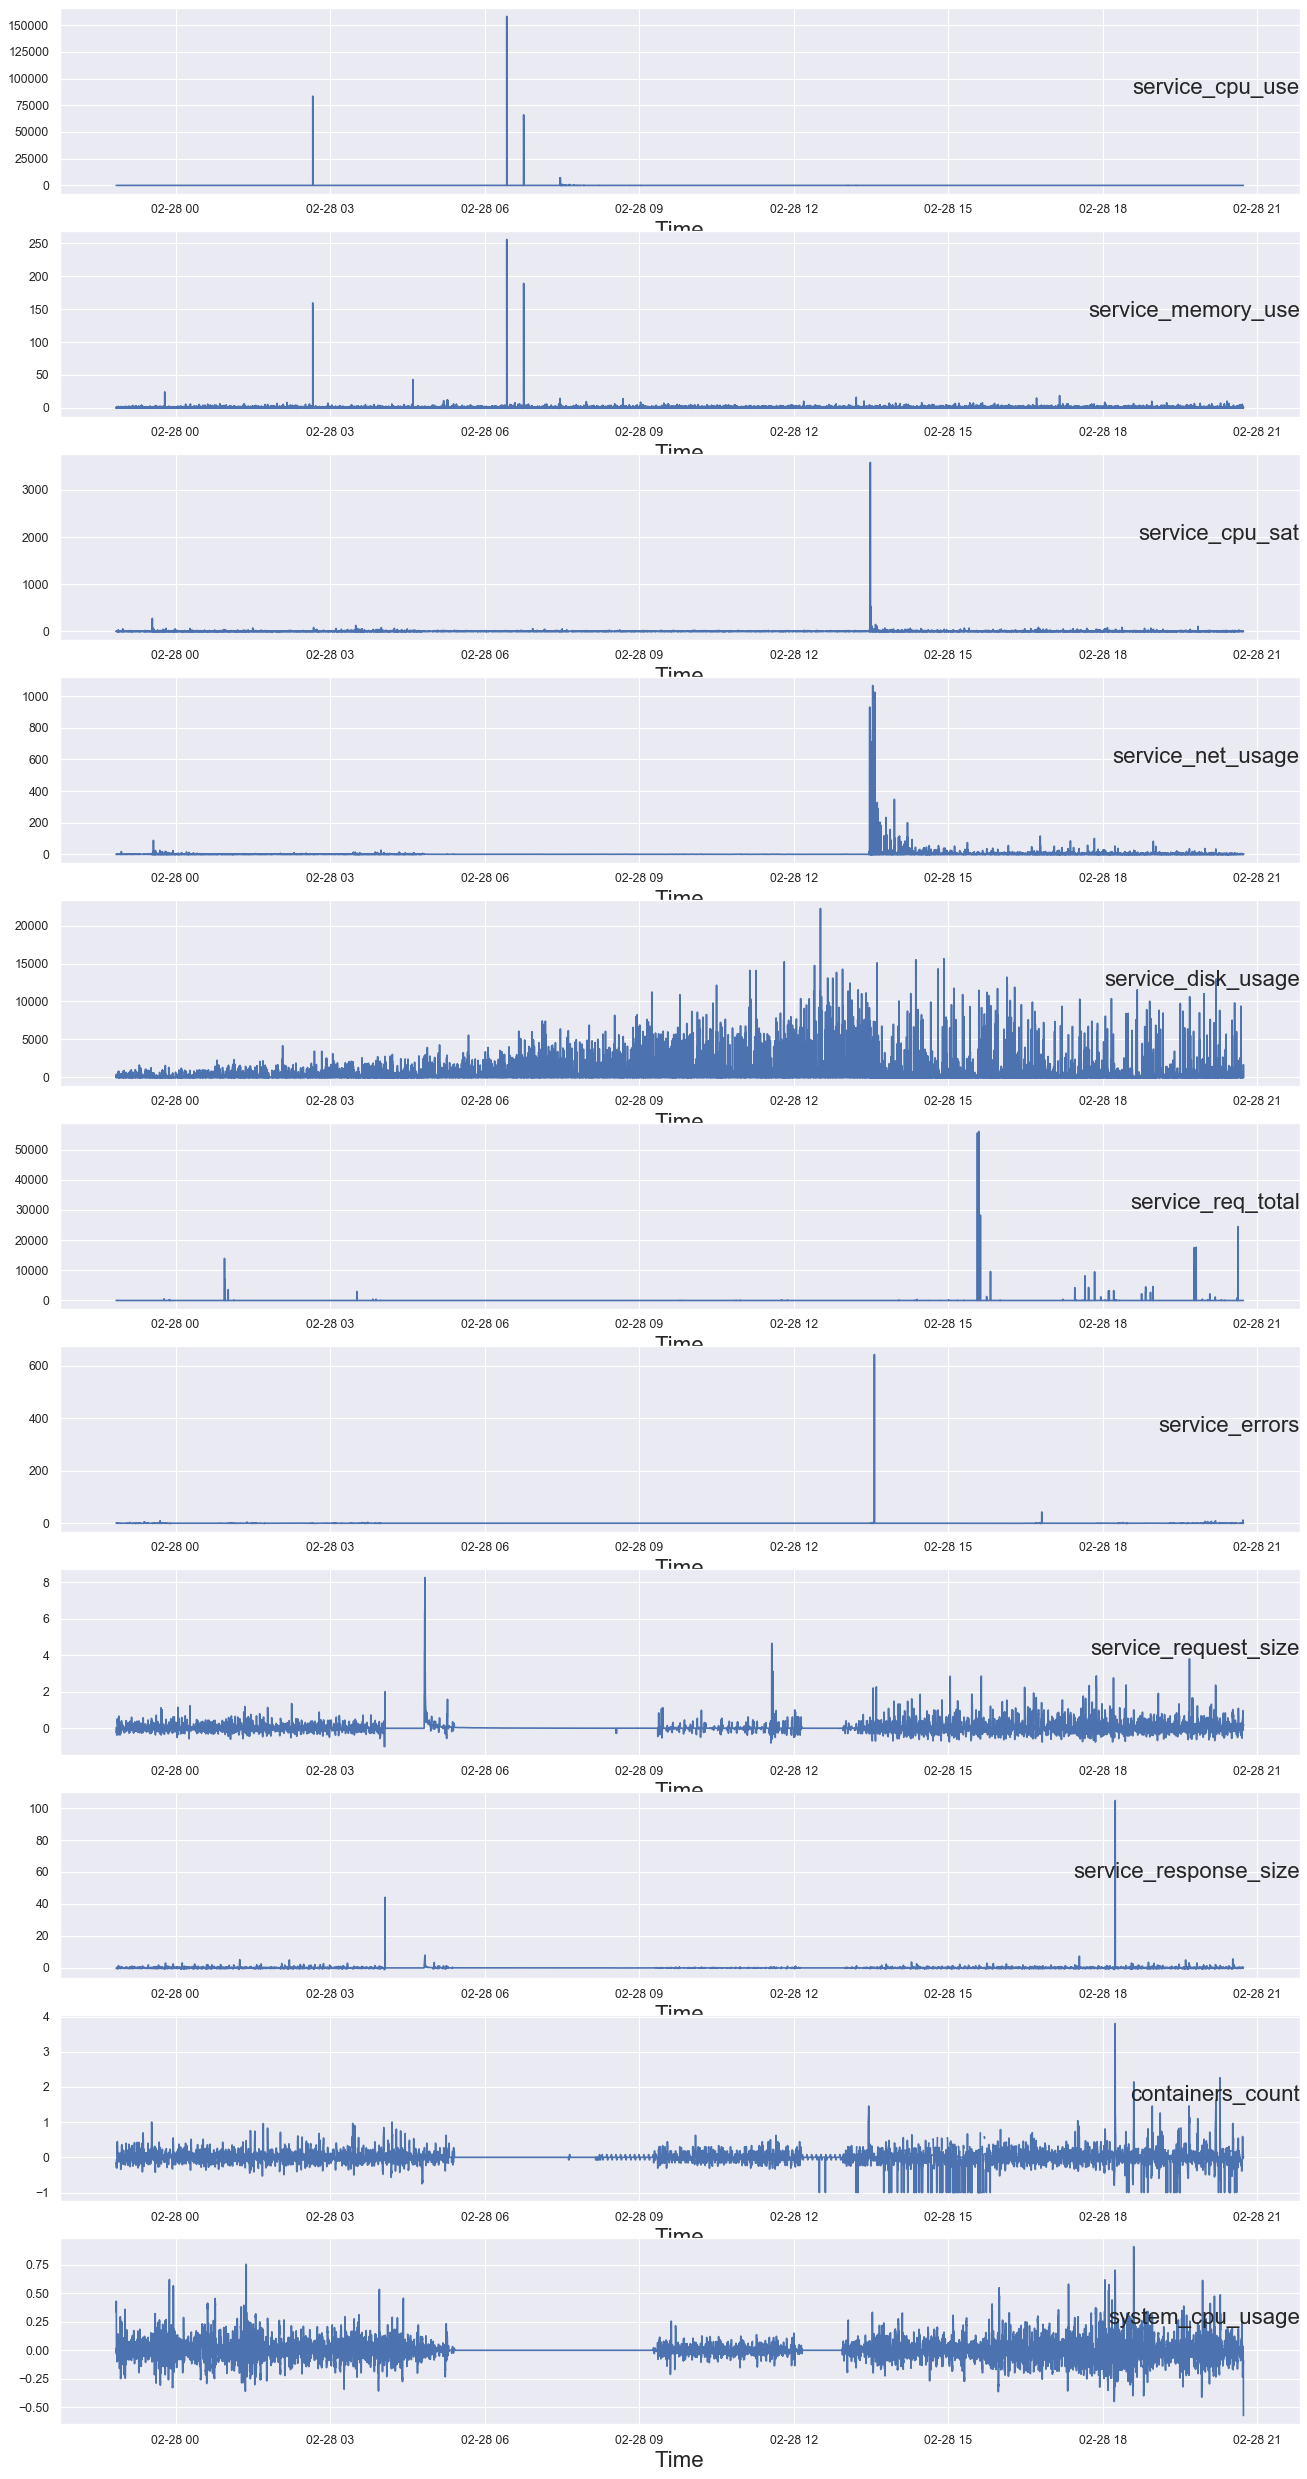

In [18]:
rows = len(features)
i = 1
plt.figure(figsize=(20, 40), dpi=80, facecolor='w', edgecolor='k')

for feature in features:
    feature_series = features_df[feature]
    plt.subplot(rows, 1, i)
    plt.plot(feature_series)
    plt.title(feature, y=0.5, loc='right', fontsize=20)
    plt.xlabel('Time', fontsize=20)
    i += 1
     
plt.show()


In [19]:
# drop system_net_sat and system_disk_sat and system_disk_io
#metrics_df = metrics_df.drop('system_net_sat', 1)
#metrics_df = metrics_df.drop('system_disk_sat', 1)
#metrics_df = metrics_df.drop('system_disk_io', 1)

features_df.head(10)

,service_cpu_use,service_memory_use,service_cpu_sat,service_net_usage,service_disk_usage,service_req_total,service_errors,service_request_size,service_response_size,containers_count,system_cpu_usage
date,,,,,,,,,,,
2020-02-27 22:50:53,0.86,0.88,-0.13,-0.14,2.27,1.00,1.57,0.03,-0.22,-0.16,0.34
2020-02-27 22:50:54,0.19,-0.20,-0.13,-0.02,0.98,0.01,0.66,-0.22,-0.31,-0.16,0.34
2020-02-27 22:50:55,0.18,-0.07,0.02,0.03,2.06,0.01,0.66,-0.22,-0.31,-0.16,0.34
2020-02-27 22:50:56,-0.10,-0.20,-0.76,0.07,-0.45,0.01,0.66,-0.22,-0.31,-0.16,0.41
2020-02-27 22:50:57,-0.19,-0.13,-0.76,0.09,-0.45,0.01,0.66,-0.22,-0.31,-0.16,0.41
2020-02-27 22:50:58,-0.02,0.12,0.33,-0.02,0.62,0.01,0.66,-0.22,-0.31,-0.16,0.43
2020-02-27 22:50:59,-0.10,-0.43,0.30,-0.09,-0.09,0.01,0.66,-0.22,-0.31,-0.16,0.43
2020-02-27 22:51:00,0.23,-0.47,0.34,-0.23,-0.42,0.01,0.66,-0.22,-0.31,-0.16,0.43
2020-02-27 22:51:01,0.15,-0.54,0.59,-0.37,1.11,0.01,0.66,-0.22,-0.31,-0.16,0.43


In [20]:
# check any null
features_df.isnull().sum() * 100 / features_df.shape[0]

service_cpu_use         0.00
service_memory_use      0.00
service_cpu_sat         0.00
service_net_usage       0.00
service_disk_usage      0.00
service_req_total       0.00
service_errors          0.00
service_request_size    0.00
service_response_size   0.00
containers_count        0.23
system_cpu_usage        0.00
dtype: float64

# Concatenate features and target dataframes

In [21]:
all_data = pd.concat([features_df, target_df], axis=1)
all_data = all_data[all_data['service_ltcy_200'].notna()]

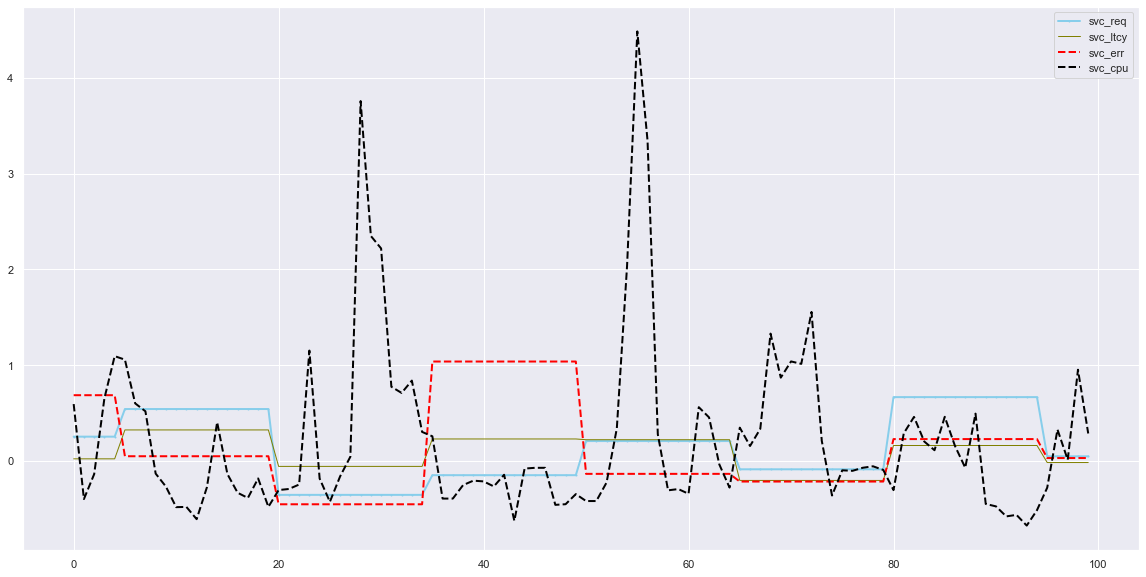

In [22]:
plt_df = pd.DataFrame()

xlen=100
rng = [i for i in range(0,xlen)]
rng_df = pd.Series(rng)
plt_df['seq'] = rng_df
plt_df['svc_req'] = pd.Series(all_data[xlen:].service_request_size.values)
plt_df['svc_ltcy'] = pd.Series(all_data[xlen:].service_ltcy_200.values)
plt_df['svc_cpu'] = pd.Series(all_data[xlen:].service_cpu_use.values)
plt_df['svc_err'] = pd.Series(all_data[xlen:].service_errors.values)

plt.figure(figsize=(20,10))
plt.plot( 'seq', 'svc_req', data=plt_df, marker='o', markerfacecolor='blue', markersize=1, color='skyblue', linewidth=2)
plt.plot( 'seq', 'svc_ltcy', data=plt_df, marker='', color='olive', linewidth=1)
plt.plot( 'seq', 'svc_err', data=plt_df, marker='', color='red', linewidth=2, linestyle='dashed')
plt.plot( 'seq', 'svc_cpu', data=plt_df, marker='', color='black', linewidth=2, linestyle='dashed')
plt.legend()


# Add Data

Let's a signal to indicate day and time of the the metric 

In [23]:
samples = all_data.shape[0]
samples

78780

In [24]:
#metrics_df['Hour'] = metrics_df.index.hour 
all_data['time'] = (all_data.index.values - all_data.index.values.astype('datetime64[D]'))/np.timedelta64(1,'s')
all_data.head(100)


,service_cpu_use,service_memory_use,service_cpu_sat,service_net_usage,service_disk_usage,service_req_total,service_errors,service_request_size,service_response_size,containers_count,system_cpu_usage,service_ltcy_200,time
date,,,,,,,,,,,,,
2020-02-27 22:50:54,0.19,-0.20,-0.13,-0.02,0.98,0.01,0.66,-0.22,-0.31,-0.16,0.34,-0.23,82254.00
2020-02-27 22:50:55,0.18,-0.07,0.02,0.03,2.06,0.01,0.66,-0.22,-0.31,-0.16,0.34,-0.23,82255.00
2020-02-27 22:50:56,-0.10,-0.20,-0.76,0.07,-0.45,0.01,0.66,-0.22,-0.31,-0.16,0.41,-0.23,82256.00
2020-02-27 22:50:57,-0.19,-0.13,-0.76,0.09,-0.45,0.01,0.66,-0.22,-0.31,-0.16,0.41,-0.23,82257.00
2020-02-27 22:50:58,-0.02,0.12,0.33,-0.02,0.62,0.01,0.66,-0.22,-0.31,-0.16,0.43,-0.23,82258.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-02-27 22:52:29,-0.75,-0.37,0.14,-0.18,-0.99,0.99,0.69,0.25,-0.68,0.30,-0.03,0.02,82349.00
2020-02-27 22:52:30,-0.70,-0.36,1.17,-0.32,-0.85,0.99,0.69,0.25,-0.68,0.30,-0.03,0.02,82350.00
2020-02-27 22:52:31,0.22,-0.15,-0.21,-0.34,-0.71,0.99,0.69,0.25,-0.68,0.30,-0.03,0.02,82351.00


## Save Metrics TimeSeries Data

In [25]:
if SAVE:
    all_data.sort_index()
    all_data.to_csv(output_dir + output_file)